### Project Introduction
For the deep learning project, I'll be creating a model to predict AI generated text. 

### Algorithm
I'll be using Word2Vec, a groundbreaking algorithm in the field on NLP that was created by Google in 2013. Word2Vec introduced the dense, low-dimensional embeddings using neural nets that were capable of capturing deeper semantic and syntactic word similarities. This was a significant advance because it allowed models to understand relationships like "king" being related to "queen" similarly to how "man" is related to "woman" through vector arithmetic. 

I'll also need to pair Word2vec with a classifier. A classifier neural network takes those word embeddings (or sentence-level embeddings like the average of word vectors) as input and learns to map them to specific labels.

### Motivaton
Since the creation of ChatGPT by OpenAI, there has been an explosion of AI generated text. It's important to detect AI generated text to prevent fraud, misinformation, and accountability. 

### Dataset
I'll be using a dataset from Kaggle, which was part of the "LLM - Detect AI Generated Text" competition. The dataset description provided by Kaggle states:
"The competition dataset comprises about 10,000 essays, some written by students and some generated by a variety of large language models (LLMs)®. The goal of the competition is to determine whether or not essay was generated by an LLM.

All of the essays were written in response to one of seven essay prompts. In each prompt, the students were instructed to read one or more source texts and then write a response. This same information may or may not have been provided as input to an LLM when generating an essay.

Essays from two of the prompts compose the training set; the remaining essays compose the hidden test set. Nearly all of the training set essays were written by students, with only a few generated essays given as examples. You may wish to generate more essays to use as training data.
"

The comment from the competition description about generating more datasets to use is accurate, and I'll note the issues with current data during the EDA portion of the project. 

To augment the training data, I'll be using a dataset that contains AI generated text from a variety of models, including LLAMA 70B, Anthropic's Claude, and others.
https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset

In [1]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score  
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer
from torch.optim import AdamW 
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import numpy as np


## EDA

In [2]:
sample_submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train_prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')

In [3]:
print("Sample Submission Data:\n", sample_submission.head(), "\n")
print("Test Essays Data:\n", test.head(), "\n")
print("Train Essays Data:\n", train.head(), "\n")
print("Train Prompts Data:\n", train_prompts.head(), "\n")


Sample Submission Data:
          id  generated
0  0000aaaa        0.1
1  1111bbbb        0.9
2  2222cccc        0.4 

Test Essays Data:
          id  prompt_id          text
0  0000aaaa          2  Aaa bbb ccc.
1  1111bbbb          3  Bbb ccc ddd.
2  2222cccc          4  CCC ddd eee. 

Train Essays Data:
          id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0   

Train Prompts Data:
    prompt_id                       prompt_name  \
0          0                   Car-free cities   
1          1  Do

There is only two different prompts in the dataset. This is an issue because there is semantic similiarity in the essay responses. A model that is trained on this data will overfit and have issues predicting whether the text is AI generated or not when it comes to different prompts.

In [4]:
print("Missing Values in Sample Submission:\n", sample_submission.isnull().sum(), "\n")
print("Missing Values in Test Essays:\n", test.isnull().sum(), "\n")
print("Missing Values in Train Essays:\n", train.isnull().sum(), "\n")
print("Missing Values in Train Prompts:\n", train_prompts.isnull().sum(), "\n")

Missing Values in Sample Submission:
 id           0
generated    0
dtype: int64 

Missing Values in Test Essays:
 id           0
prompt_id    0
text         0
dtype: int64 

Missing Values in Train Essays:
 id           0
prompt_id    0
text         0
generated    0
dtype: int64 

Missing Values in Train Prompts:
 prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64 



In [5]:
print("Summary Statistics for Sample Submission:\n", sample_submission.describe(), "\n")
print("Summary Statistics for Test Essays:\n", test.describe(), "\n")
print("Summary Statistics for Train Essays:\n", train.describe(), "\n")
print("Summary Statistics for Train Prompts:\n", train_prompts.describe(), "\n")

Summary Statistics for Sample Submission:
        generated
count   3.000000
mean    0.466667
std     0.404145
min     0.100000
25%     0.250000
50%     0.400000
75%     0.650000
max     0.900000 

Summary Statistics for Test Essays:
        prompt_id
count        3.0
mean         3.0
std          1.0
min          2.0
25%          2.5
50%          3.0
75%          3.5
max          4.0 

Summary Statistics for Train Essays:
          prompt_id    generated
count  1378.000000  1378.000000
mean      0.486212     0.002177
std       0.499991     0.046625
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     0.000000
75%       1.000000     0.000000
max       1.000000     1.000000 

Summary Statistics for Train Prompts:
        prompt_id
count   2.000000
mean    0.500000
std     0.707107
min     0.000000
25%     0.250000
50%     0.500000
75%     0.750000
max     1.000000 



In [6]:
generated_counts = train['generated'].value_counts(normalize=True)
print(generated_counts)


generated
0    0.997823
1    0.002177
Name: proportion, dtype: float64


0 is for human written essays, while 1 is for AI generated. Let's see the count.

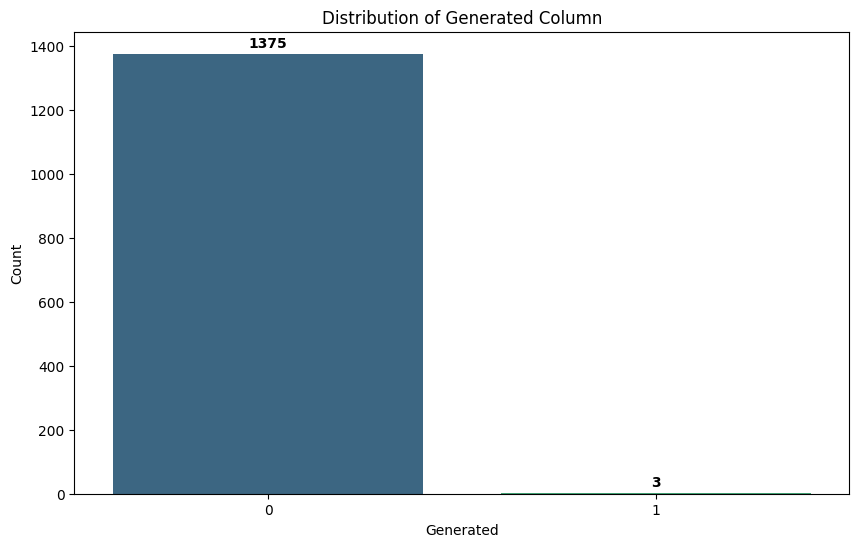

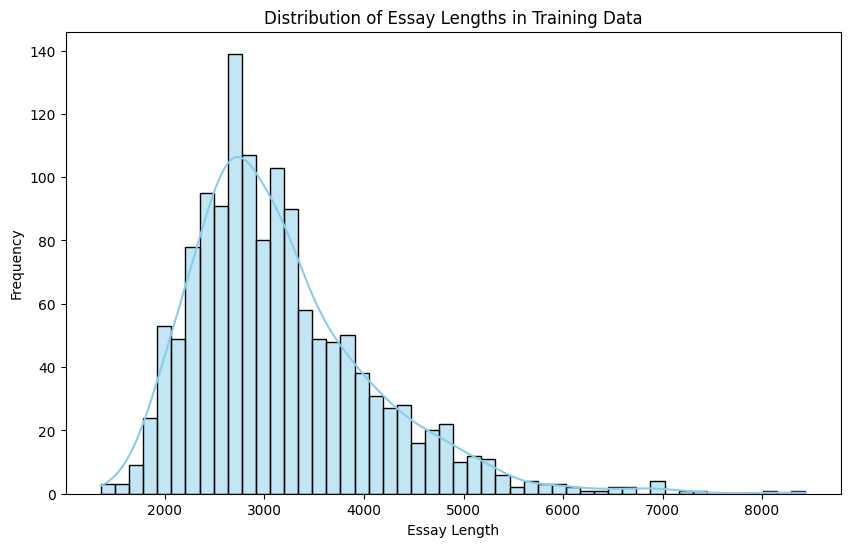

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts for the 'generated' column
generated_counts = train['generated'].value_counts()
generated_proportions = train['generated'].value_counts(normalize=True)

# Plot the distribution of the 'generated' column with counts
plt.figure(figsize=(10, 6))
sns.barplot(x=generated_counts.index, y=generated_counts.values, palette='viridis')
for i, v in enumerate(generated_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.title('Distribution of Generated Column')
plt.show()

# Histogram of essay lengths in training data
train['essay_length'] = train['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train['essay_length'], bins=50, kde=True, color='skyblue')
plt.xlabel('Essay Length')
plt.ylabel('Frequency')
plt.title('Distribution of Essay Lengths in Training Data')
plt.show()

As we see, there are **1378** humans written essays compared to only **3** that is AI generated. Multinomial Naive Bayes models estimate the probability of each class based on the frequency of each class in the training data. With a severe class imbalance, the prior probability of the minority class becomes very small, leading to a strong bias towards the majority class because the minority class's data is not learned.

We need to remedy this by using another dataset. I'll be using a dataset that contains AI generated text from a variety of LLM's, including LLAMA 70B, Anthropic's Claude, and others.

## EDA & Cleaning for Augmented Dataset

In [8]:
# Data Loading and Preprocessing
train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
external_train = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
external_train.rename(columns={'generated': 'label'}, inplace=True)
train = pd.concat([train, external_train], ignore_index=True)
train['text'] = train['text'].str.replace('\n', ' ', regex=True)

test['text'] = test['text'].str.replace('\n', ' ', regex=True)


In [9]:
duplicate_rows = train[train.duplicated()]
duplicate_rows.shape

(0, 7)

In [14]:
# Display information about the datasets
print('Augmented training: ', train.shape)
print("Augmented Train Essays Data:\n", train.sample(10), "\n")
print("Missing Values in Train Essays:\n", train.isnull().sum(), "\n")
print("Summary Statistics for Train Essays:\n", train.describe(), "\n")


Augmented training:  (46246, 7)
Augmented Train Essays Data:
                                                     text  label  \
808    Some drivers think it's ok to text and drive. ...      0   
17252  Cars that drive them selves shouldn't be devel...      0   
8939   The author uses and explains many ways how to ...      0   
18480  I did not know that there are driverless cars ...      0   
6131   Reasons to join the Seagoing Cowboys program a...      0   
42645  Since the industrial revolution the demand for...      0   
13852  Dear, principal  I am writing this letter to y...      0   
15465  Dear Principal ,  I think that that you should...      0   
13330  Many people and other scientists believe that ...      0   
9109   Venus is a planet in our solar system, which i...      0   

                                 prompt_name           source RDizzl3_seven  \
808                       Phones and driving  persuade_corpus         False   
17252                        Driverless ca

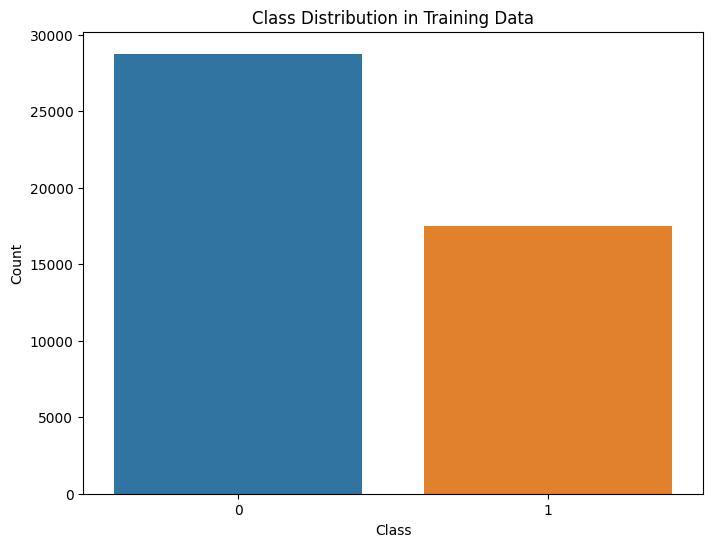

In [7]:
# Class distribution in training data
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

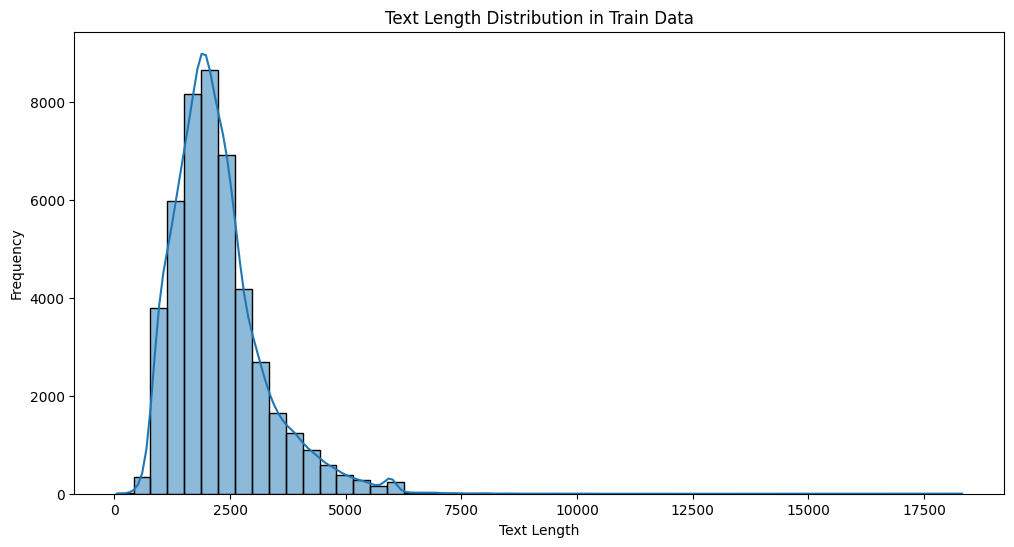

In [8]:
train['text_length'] = train['text'].apply(len)

# Distribution of text lengths in the test data
plt.figure(figsize=(12, 6))
sns.histplot(train['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution in Train Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Looks like there are some outliers, but it shouldn't matter because uring training, Word2Vec does not give disproportionate importance to long documents because word embeddings are learned across all the words in the corpus. The algorithm aggregates information from various texts and treats words as independent occurrences across the whole dataset.

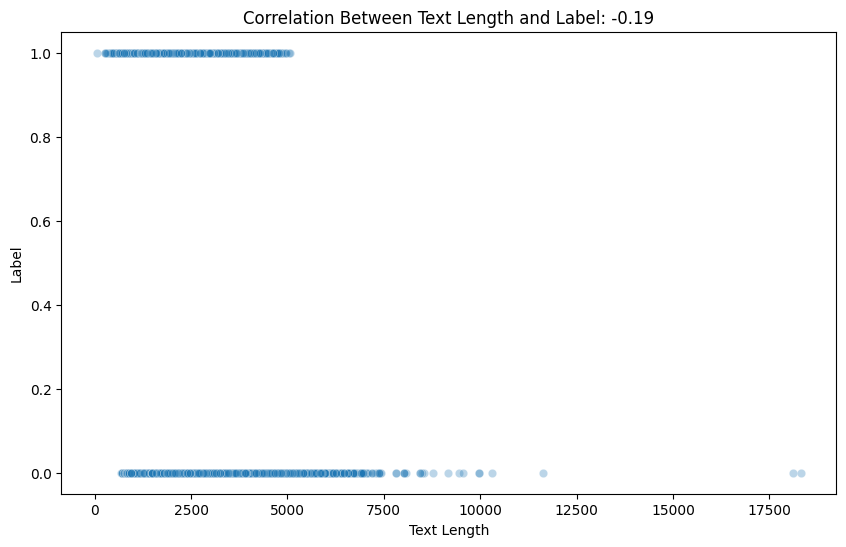

In [11]:
text_length_label_corr = train[['text_length', 'label']].corr().iloc[0, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='label', data=train, alpha=0.3)
plt.title(f'Correlation Between Text Length and Label: {text_length_label_corr:.2f}')
plt.xlabel('Text Length')
plt.ylabel('Label')
plt.show()

A correlation of -0.16 indicates a weak negative relationship between text length and the label. You can see that the points in the plot show that most of the data for label "1" is clustered around shorter text lengths (near 6000 characters) while texts with label "0" have a wider distribution of lengths.

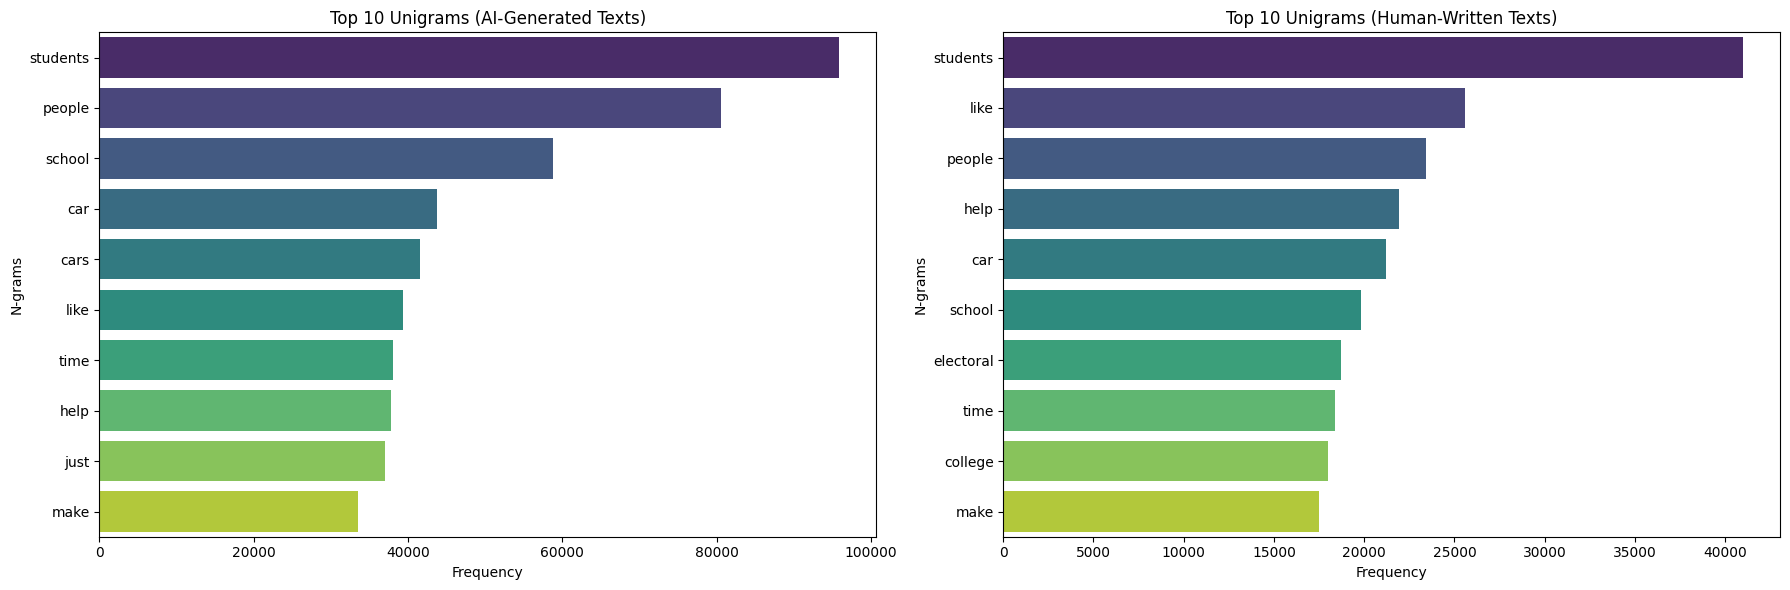

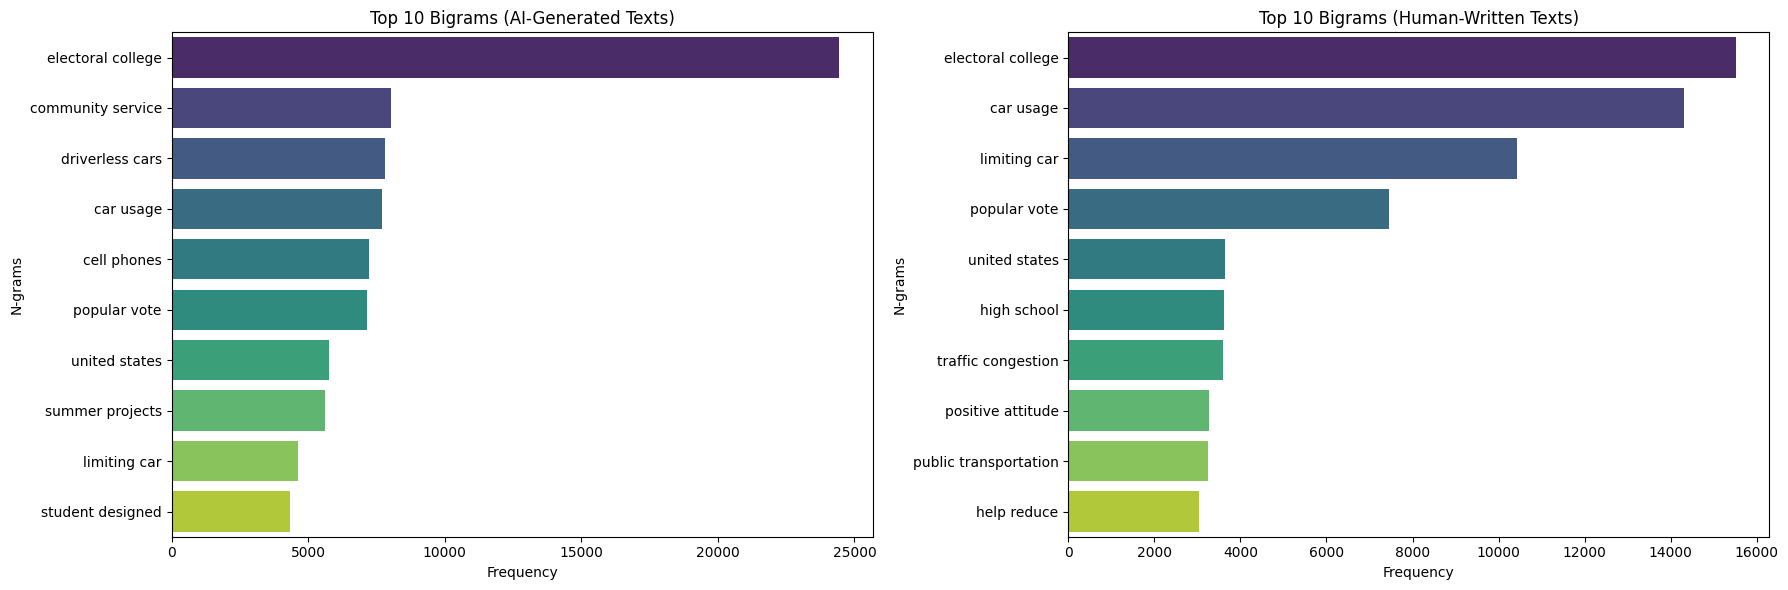

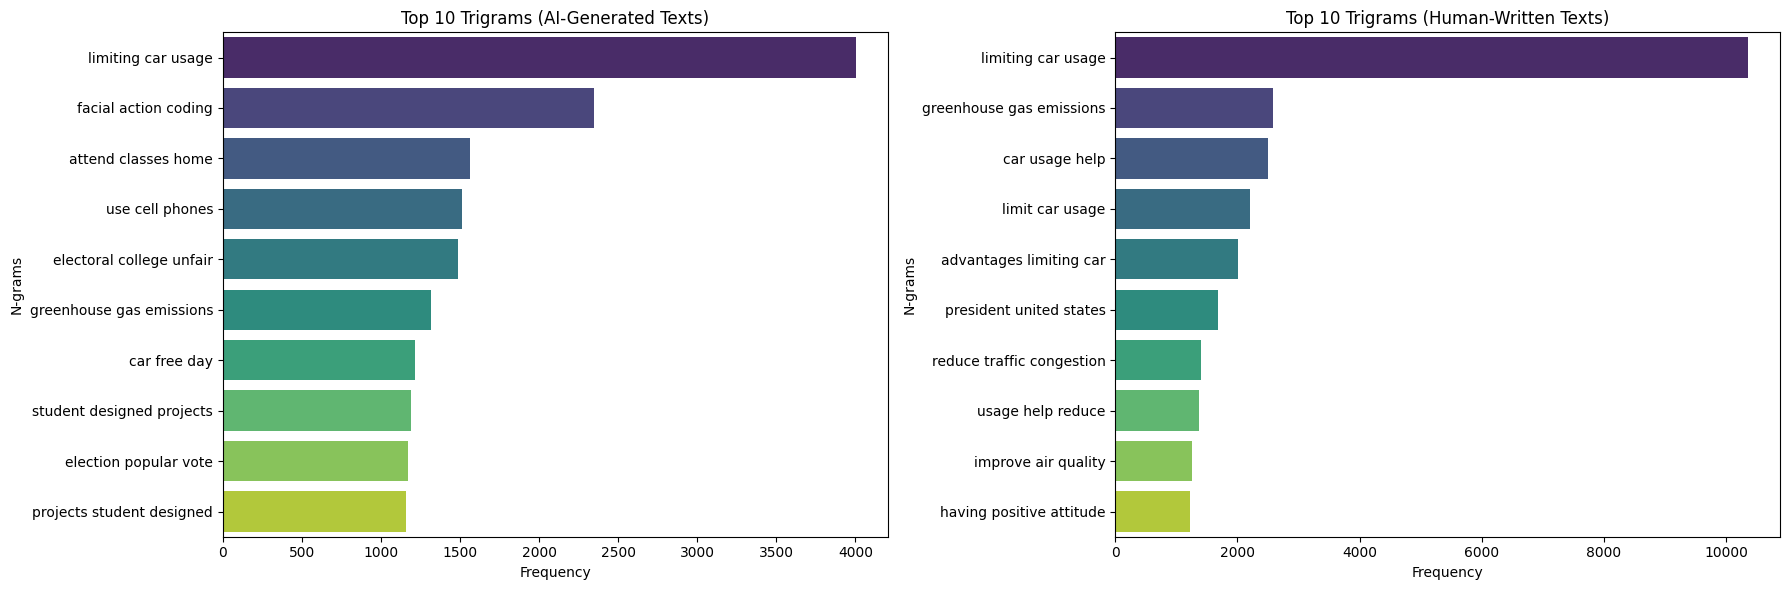

In [12]:

ai_generated = train[train['label'] == 0]['text']
human_written = train[train['label'] == 1]['text']

def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top 10 unigrams, bigrams, and trigrams for AI-generated and human-written texts
top_unigrams_ai = get_top_ngrams(ai_generated, n=10, ngram_range=(1, 1))
top_bigrams_ai = get_top_ngrams(ai_generated, n=10, ngram_range=(2, 2))  
top_trigrams_ai = get_top_ngrams(ai_generated, n=10, ngram_range=(3, 3))  

top_unigrams_human = get_top_ngrams(human_written, n=10, ngram_range=(1, 1))
top_bigrams_human = get_top_ngrams(human_written, n=10, ngram_range=(2, 2))
top_trigrams_human = get_top_ngrams(human_written, n=10, ngram_range=(3, 3))

# Convert results to DataFrames for better readability
df_unigrams_ai = pd.DataFrame(top_unigrams_ai, columns=['Unigram', 'Frequency'])
df_bigrams_ai = pd.DataFrame(top_bigrams_ai, columns=['Bigram', 'Frequency'])
df_trigrams_ai = pd.DataFrame(top_trigrams_ai, columns=['Trigram', 'Frequency'])

df_unigrams_human = pd.DataFrame(top_unigrams_human, columns=['Unigram', 'Frequency'])
df_bigrams_human = pd.DataFrame(top_bigrams_human, columns=['Bigram', 'Frequency'])
df_trigrams_human = pd.DataFrame(top_trigrams_human, columns=['Trigram', 'Frequency'])

def plot_side_by_side(ngram_df_ai, ngram_df_human, title_ai, title_human):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot for AI-Generated Texts
    sns.barplot(x='Frequency', y=ngram_df_ai[ngram_df_ai.columns[0]], data=ngram_df_ai, palette='viridis', ax=axes[0])
    axes[0].set_title(title_ai)
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('N-grams')

    # Plot for Human-Written Texts
    sns.barplot(x='Frequency', y=ngram_df_human[ngram_df_human.columns[0]], data=ngram_df_human, palette='viridis', ax=axes[1])
    axes[1].set_title(title_human)
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('N-grams')

    plt.tight_layout()
    plt.show()

plot_side_by_side(df_unigrams_ai, df_unigrams_human, "Top 10 Unigrams (AI-Generated Texts)", "Top 10 Unigrams (Human-Written Texts)")
plot_side_by_side(df_bigrams_ai, df_bigrams_human, "Top 10 Bigrams (AI-Generated Texts)", "Top 10 Bigrams (Human-Written Texts)")
plot_side_by_side(df_trigrams_ai, df_trigrams_human, "Top 10 Trigrams (AI-Generated Texts)", "Top 10 Trigrams (Human-Written Texts)")

The word choices from LLM's and human are quite similiar, but there are some noticable differences. For example, LLM's use the bigram "driverless car" much more frequently than humans while humans use the term "limiting car" much more frequently than the LLMs. For trigrams, there were many that have been written by LLM's but were absent in the top 10 human written text. For exampl,e, LLM's used the trigrams "facial action coding", "electoral college unfair", and other trigrams that were not present in the top 10 human written trigrams. 

## Model 1 - Word2vec with vector size of 100 w/ 2 layer classifier

In [7]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return tokens

train['tokens'] = train['text'].apply(tokenize)
test['tokens'] = test['text'].apply(tokenize)

all_tokens = train['tokens'].tolist()



In [ ]:
pretrained_model_path = "/kaggle/input/w2v-model/w2v.model"

word2vec_params = {
    'vector_size': 100,  
    'window': 5,
    'min_count': 2,
    'workers': 4,
    'sg': 1,
    'epochs': 10
}

# Check if the model already exists
if os.path.exists(pretrained_model_path):
    print("Loading existing Word2Vec model...")
    w2v_model = Word2Vec.load(pretrained_model_path)
else:
    print("No pre-trained model found. Training a new Word2Vec model...")
    w2v_model = Word2Vec(sentences=all_tokens, **word2vec_params)
    w2v_model.save("word2vec.model") 

1. **`vector_size`**: This parameter sets the dimensionality of the word vectors, meaning each word will be represented as a 100-dimensional vector.
2. **`window`**: Defines the maximum distance between the current and predicted word within a sentence, with a context window size of 5 words.
3. **`min_count`**: Words that occur less than 2 times in the corpus will be ignored, reducing the noise from rare words.
4. **`workers`**: The number of CPU cores to use during training, allowing parallel processing for efficiency, with 4 workers specified here.
5. **`sg`**: Indicates the training algorithm, where 1 means Skip-gram is used (predicting context words from the current word)

In [ ]:
# Generates an average word embedding for a set of tokens, providing a single vector representation 
# For a sentence or document by averaging the individual word embeddings from the model
def get_average_embedding(tokens, model, vector_size):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        mean_vector = np.mean(vectors, axis=0)
    else:
        mean_vector = np.zeros(vector_size)
    return mean_vector

vector_size = w2v_model.vector_size

train['embedding'] = train['tokens'].apply(lambda x: get_average_embedding(x, w2v_model, vector_size))
test['embedding'] = test['tokens'].apply(lambda x: get_average_embedding(x, w2v_model, vector_size))

In [ ]:
# Prepare Data for PyTorch
X = np.vstack(train['embedding'].values)
y = train['label'].values

# Handle labels: ensure they are integers starting from 0
if not np.array_equal(np.unique(y), [0, 1]):
    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    y = np.array([label_mapping[label] for label in y])

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y
)

In [8]:

# Prepares input data and labels for use in PyTorch models by converting them into tensors
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmbeddingDataset(X_tr, y_tr)
val_dataset = EmbeddingDataset(X_val, y_val)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Once the average Word2Vec embedding is computed for each input text, it becomes a fixed-size input vector that can be fed into the classifier

Right now, we're just testing to see how well a simple model would perform.

1. The neural network has two fully connected layers (fc1 and fc2), using ReLU activation and dropout between them.
2. The hidden layer has a size of 128 neurons.
3. A dropout of 0.5 is used after the ReLU activation to randomly deactivate 50% of neurons during training, helping to prevent overfitting and improve generalization. 0.5 is commonly used
4. CrossEntropyLoss is a loss function used in classification tasks that measures the difference between the predicted probability distribution and the true class labels, penalizing incorrect predictions more heavily the further they are from the correct label.

In [5]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.5):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = vector_size
hidden_size = 128
num_classes = 2  # Binary classification

model = Classifier(input_size, hidden_size, num_classes)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Classifier(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


Epoch [1/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 931.50it/s]


Epoch [1/20]
Train Loss: 0.0532 | Train Acc: 0.9821 | Train F1: 0.9820
Val Loss: 0.0447 | Val Acc: 0.9856 | Val F1: 0.9856 | Val ROC AUC: 0.9981


Epoch [2/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 699.59it/s]


Epoch [2/20]
Train Loss: 0.0530 | Train Acc: 0.9829 | Train F1: 0.9829
Val Loss: 0.0453 | Val Acc: 0.9853 | Val F1: 0.9853 | Val ROC AUC: 0.9982


Epoch [3/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 880.70it/s]


Epoch [3/20]
Train Loss: 0.0518 | Train Acc: 0.9837 | Train F1: 0.9836
Val Loss: 0.0445 | Val Acc: 0.9859 | Val F1: 0.9859 | Val ROC AUC: 0.9982


Epoch [4/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 871.09it/s]


Epoch [4/20]
Train Loss: 0.0507 | Train Acc: 0.9830 | Train F1: 0.9829
Val Loss: 0.0438 | Val Acc: 0.9858 | Val F1: 0.9858 | Val ROC AUC: 0.9982


Epoch [5/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 963.82it/s]


Epoch [5/20]
Train Loss: 0.0506 | Train Acc: 0.9837 | Train F1: 0.9837
Val Loss: 0.0436 | Val Acc: 0.9854 | Val F1: 0.9854 | Val ROC AUC: 0.9982


Epoch [6/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 975.57it/s]


Epoch [6/20]
Train Loss: 0.0497 | Train Acc: 0.9842 | Train F1: 0.9842
Val Loss: 0.0416 | Val Acc: 0.9864 | Val F1: 0.9864 | Val ROC AUC: 0.9984


Epoch [7/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 965.73it/s]


Epoch [7/20]
Train Loss: 0.0481 | Train Acc: 0.9842 | Train F1: 0.9842
Val Loss: 0.0421 | Val Acc: 0.9858 | Val F1: 0.9858 | Val ROC AUC: 0.9984


Epoch [8/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 947.56it/s]


Epoch [8/20]
Train Loss: 0.0466 | Train Acc: 0.9846 | Train F1: 0.9845
Val Loss: 0.0411 | Val Acc: 0.9867 | Val F1: 0.9867 | Val ROC AUC: 0.9984


Epoch [9/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 893.64it/s]


Epoch [9/20]
Train Loss: 0.0464 | Train Acc: 0.9847 | Train F1: 0.9847
Val Loss: 0.0424 | Val Acc: 0.9866 | Val F1: 0.9866 | Val ROC AUC: 0.9985


Epoch [10/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 913.93it/s]


Epoch [10/20]
Train Loss: 0.0464 | Train Acc: 0.9852 | Train F1: 0.9852
Val Loss: 0.0440 | Val Acc: 0.9868 | Val F1: 0.9868 | Val ROC AUC: 0.9984


Epoch [11/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 897.30it/s]


Epoch [11/20]
Train Loss: 0.0470 | Train Acc: 0.9849 | Train F1: 0.9848
Val Loss: 0.0408 | Val Acc: 0.9866 | Val F1: 0.9866 | Val ROC AUC: 0.9985


Epoch [12/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 923.77it/s]


Epoch [12/20]
Train Loss: 0.0452 | Train Acc: 0.9852 | Train F1: 0.9852
Val Loss: 0.0399 | Val Acc: 0.9867 | Val F1: 0.9867 | Val ROC AUC: 0.9986


Epoch [13/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 863.30it/s]


Epoch [13/20]
Train Loss: 0.0436 | Train Acc: 0.9850 | Train F1: 0.9850
Val Loss: 0.0385 | Val Acc: 0.9875 | Val F1: 0.9874 | Val ROC AUC: 0.9987


Epoch [14/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 959.89it/s]


Epoch [14/20]
Train Loss: 0.0453 | Train Acc: 0.9853 | Train F1: 0.9853
Val Loss: 0.0399 | Val Acc: 0.9871 | Val F1: 0.9871 | Val ROC AUC: 0.9987


Epoch [15/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 911.06it/s]


Epoch [15/20]
Train Loss: 0.0433 | Train Acc: 0.9855 | Train F1: 0.9855
Val Loss: 0.0396 | Val Acc: 0.9883 | Val F1: 0.9883 | Val ROC AUC: 0.9988


Epoch [16/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 877.43it/s]


Epoch [16/20]
Train Loss: 0.0425 | Train Acc: 0.9861 | Train F1: 0.9861
Val Loss: 0.0479 | Val Acc: 0.9836 | Val F1: 0.9835 | Val ROC AUC: 0.9986


Epoch [17/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 966.18it/s]


Epoch [17/20]
Train Loss: 0.0437 | Train Acc: 0.9858 | Train F1: 0.9858
Val Loss: 0.0406 | Val Acc: 0.9857 | Val F1: 0.9857 | Val ROC AUC: 0.9987


Epoch [18/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 963.35it/s]


Epoch [18/20]
Train Loss: 0.0427 | Train Acc: 0.9862 | Train F1: 0.9862
Val Loss: 0.0366 | Val Acc: 0.9878 | Val F1: 0.9878 | Val ROC AUC: 0.9988


Epoch [19/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 965.34it/s]


Epoch [19/20]
Train Loss: 0.0422 | Train Acc: 0.9865 | Train F1: 0.9865
Val Loss: 0.0401 | Val Acc: 0.9869 | Val F1: 0.9869 | Val ROC AUC: 0.9986


Epoch [20/20] Validation: 100%|██████████| 145/145 [00:00<00:00, 969.86it/s]


Epoch [20/20]
Train Loss: 0.0407 | Train Acc: 0.9865 | Train F1: 0.9865
Val Loss: 0.0366 | Val Acc: 0.9878 | Val F1: 0.9878 | Val ROC AUC: 0.9987
Early stopping triggered after 20 epochs
Best validation F1: 0.9883


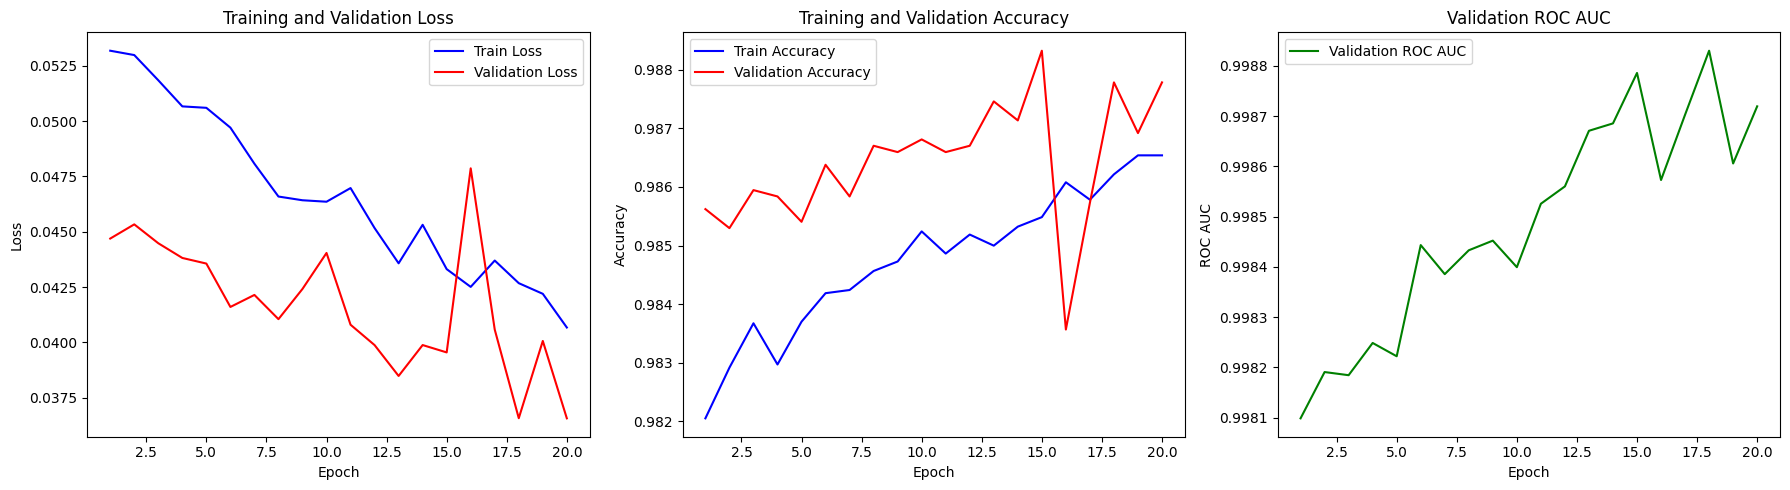

In [ ]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store metrics for each epoch
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_roc_auc_scores = []

best_val_f1 = 0.0
best_model_state = None
early_stopping_patience = 5
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Using tqdm to visualize the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    
    # Single training step for each batch in the dataset
    # Computing the model's predictions, calculating the loss, performing backpropagation, updating the model weights
    for batch_X, batch_y in train_loader_tqdm:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    epoch_loss /= len(train_loader.dataset)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Append training metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    val_probs = []  # To store probabilities for ROC AUC
    
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
        for batch_X, batch_y in val_loader_tqdm:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            val_probs.extend(probs.cpu().numpy())
            
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    # Compute ROC AUC
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = 0.0  # If only one class is present in y_true, ROC AUC is not defined
    
    # Append validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_roc_auc_scores.append(val_roc_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f} | Val ROC AUC: {val_roc_auc:.4f}")
    
    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        early_stopping_counter = 0  # Reset the counter if we have a new best
    else:
        early_stopping_counter += 1
    
    # Early stopping check
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Best validation F1: {best_val_f1:.4f}")

# Plotting Metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_roc_auc_scores, 'g-', label='Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()


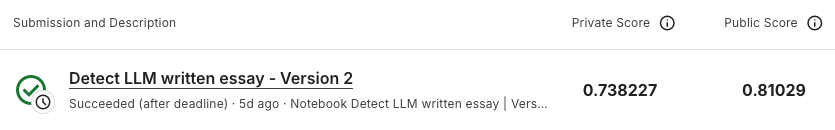

In [6]:
from IPython.display import display
from PIL import Image

img = Image.open("img1.png")

display(img)


#### Results
- Both training and validation loss show a downward trend, indicating that the model is learning and fitting the data well. Training loss is a bit lower than validation loss, which is expected
- Both training and validation accuracy show an upward trend, both being over 0.985 by epoch 20.
- The ROC AUC values are very high (approaching 1.0), which suggests strong classification performance on the validation data

While the model shows a strong ROCAUC score - what matters is how it performed on kaggle, as the private score on kaggle is based on a part of the test dataset that is not visible during the model training and validation process. It indicates how well the model generalizes to unseen data on a broader scope. The model yielded a private score of 0.738. The highest score on kaggle's private leaderboard was 0.98. We'll not take into account the public score because it has a smaller test dataset compared to the dataset used for the private score. Also, the private score is what is used as the official kaggle leaderboard

The difference in score may indicate that that is an issue with overfitting to the training set. Kaggle's test set may use outputs that are from different LLM's.

## Model 2 - Word2vec tuned

For the word2vec params, we'll do the following:
1. Increase the **vector_size** to 300 from 100. A larger vector size provides more capacity for the embedding to encode various aspects of a word’s meaning, such as context, associations with other words, and syntactic or semantic features.
2. Increase **min_count** to 5 from 2. Word2vec's default min_count is 5, so hopefully this could reduce noise
3. Use **Continuous Bag of Words (CBOW)** instead of **skip-gram**. CBOW is better at handling frequent words in large datasets, as it averages the context and focuses on predicting the most likely target word
4. Use **20 epochs** instead of 10

In [9]:
import os
pretrained_model_path = "/kaggle/input/word2vec-model2/model.model"

word2vec_params = {
    'vector_size': 300, 
    'window': 5,
    'min_count': 7,
    'workers': 4,
    'sg': 0,  
    'epochs': 20
}

# Check if the model already exists
if os.path.exists(pretrained_model_path):
    print("Loading existing Word2Vec model...")
    w2v_model = Word2Vec.load(pretrained_model_path)
else:
    print("No pre-trained model found. Training a new Word2Vec model...")
    w2v_model = Word2Vec(sentences=all_tokens, **word2vec_params)
    w2v_model.save("word2vec.model")  


Loading existing Word2Vec model...


Original vs optimized classifier changes:
1. **Multiple Hidden Layers**:
   - **Original**: One hidden layer with 128 units.
   - **Optimized**: Three hidden layers with 512, 256, and 128 units, adding more depth for better feature extraction.

2. **Activation Function**:
   - **Original**: Uses ReLU activation.
   - **Optimized**: Uses GELU activation for smoother gradient flow, which can lead to better performance, especially for deeper networks.

3. **Batch Normalization**:
   - **Original**: No batch normalization.
   - **Optimized**: Applies batch normalization after each hidden layer to stabilize learning and improve convergence.

4. **Dropout**:
   - **Original**: A single dropout layer with a dropout rate of 0.5 after the hidden layer.
   - **Optimized**: Dropout is applied after each hidden layer with a reduced rate of 0.3 to avoid overfitting while keeping more information during training.

5. **Weight Initialization**:
   - **Original**: Default PyTorch initialization.
   - **Optimized**: Custom weight initialization using Kaiming normal for better convergence, tailored to leaky_relu-like activations.

6. **Model Complexity**:
   - **Original**: Simpler, shallow network with two layers.
   - **Optimized**: More complex with deeper architecture and advanced regularization, better suited for learning more abstract features.



In [10]:


class OptimizedClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout=0.3):
        super(OptimizedClassifier, self).__init__()
        
        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])  
        self.activation1 = nn.GELU() 
        self.dropout1 = nn.Dropout(dropout)
        
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.activation2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)
        
        # Third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.activation3 = nn.GELU()
        self.dropout3 = nn.Dropout(dropout)
        
        # Output layer
        self.output = nn.Linear(hidden_sizes[2], num_classes)
        
        self._initialize_weights()
    
    def forward(self, x):
        # Forward pass through first hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        
        # Forward pass through second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        
        # Forward pass through third hidden layer
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        
        # Output layer
        x = self.output(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain('leaky_relu', param=0.1)
                nn.init.kaiming_normal_(m.weight, a=0.1, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Model Parameters
input_size = vector_size 
hidden_sizes = [512, 256, 128]
num_classes = 2 

model = OptimizedClassifier(input_size, hidden_sizes, num_classes, dropout=0.3)
print(model)


OptimizedClassifier(
  (fc1): Linear(in_features=300, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): GELU(approximate='none')
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): GELU(approximate='none')
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): GELU(approximate='none')
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=128, out_features=2, bias=True)
)


Loss and optimizer changes:
1. **AdamW Optimizer**:
   - **Previous**: Used the Adam optimizer, which does not directly penalize large weights.
   - **New**: Uses **AdamW**, which is a variant of Adam that includes **weight decay** for better regularization, preventing overfitting by penalizing large weights during training.

2. **Class Weights in Loss Function**:
   - **Previous**: No class balancing.
   - **New**: Introduces **class weights** in the loss function (`CrossEntropyLoss`) to address class imbalance. The weights ensure that the model pays more attention to underrepresented classes, improving performance in imbalanced datasets.

3. **Learning Rate Scheduler (ReduceLROnPlateau)**:
   - **Previous**: No learning rate scheduling.
   - **New**: Adds a **learning rate scheduler** that dynamically reduces the learning rate by a factor of 0.5 if a monitored metric (e.g., validation F1 score) doesn’t improve for a set number of epochs (3 in this case). This helps fine-tune the learning process by lowering the learning rate when progress stagnates.

4. **Weight Decay**:
   - **Previous**: No weight decay in the optimizer.
   - **New**: Includes a **weight decay** term in the optimizer, penalizing large weights, which helps improve generalization and regularization.


In [11]:

class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Initialize AdamW Optimizer with Weight Decay for regularization
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Define a Learning Rate Scheduler to Reduce LR on Plateau based on validation F1 score
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


In [12]:
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_roc_auc_scores = []

best_val_f1 = 0.0
best_model_state = None
early_stopping_patience = 5
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Using tqdm to visualize the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    
    for batch_X, batch_y in train_loader_tqdm:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    epoch_loss /= len(train_loader.dataset)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Append training metrics
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    val_probs = []  # To store probabilities for ROC AUC
    
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
        for batch_X, batch_y in val_loader_tqdm:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            val_probs.extend(probs.cpu().numpy())
            
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    # Compute ROC AUC
    try:
        val_roc_auc = roc_auc_score(val_labels, val_probs)
    except ValueError:
        val_roc_auc = 0.0  # If only one class is present in y_true, ROC AUC is not defined
    
    # Append validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_roc_auc_scores.append(val_roc_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1:.4f} | Val ROC AUC: {val_roc_auc:.4f}")
    
    # Save the best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()
        early_stopping_counter = 0  # Reset the counter if we have a new best
    else:
        early_stopping_counter += 1
    
    # Early stopping check
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Best validation F1: {best_val_f1:.4f}")



Epoch [1/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 697.29it/s]


Epoch [1/25]
Train Loss: 0.0838 | Train Acc: 0.9716 | Train F1: 0.9716
Val Loss: 0.0262 | Val Acc: 0.9919 | Val F1: 0.9919 | Val ROC AUC: 0.9995


Epoch [2/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 748.28it/s]


Epoch [2/25]
Train Loss: 0.0393 | Train Acc: 0.9875 | Train F1: 0.9875
Val Loss: 0.0272 | Val Acc: 0.9920 | Val F1: 0.9920 | Val ROC AUC: 0.9996


Epoch [3/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 759.95it/s]


Epoch [3/25]
Train Loss: 0.0298 | Train Acc: 0.9902 | Train F1: 0.9902
Val Loss: 0.0476 | Val Acc: 0.9881 | Val F1: 0.9881 | Val ROC AUC: 0.9987


Epoch [4/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 778.96it/s]


Epoch [4/25]
Train Loss: 0.0309 | Train Acc: 0.9899 | Train F1: 0.9899
Val Loss: 0.0192 | Val Acc: 0.9932 | Val F1: 0.9932 | Val ROC AUC: 0.9998


Epoch [5/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 735.78it/s]


Epoch [5/25]
Train Loss: 0.0300 | Train Acc: 0.9900 | Train F1: 0.9900
Val Loss: 0.0217 | Val Acc: 0.9942 | Val F1: 0.9942 | Val ROC AUC: 0.9998


Epoch [6/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 761.12it/s]


Epoch [6/25]
Train Loss: 0.0248 | Train Acc: 0.9916 | Train F1: 0.9916
Val Loss: 0.0174 | Val Acc: 0.9938 | Val F1: 0.9938 | Val ROC AUC: 0.9998


Epoch [7/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 774.12it/s]


Epoch [7/25]
Train Loss: 0.0220 | Train Acc: 0.9928 | Train F1: 0.9928
Val Loss: 0.0195 | Val Acc: 0.9937 | Val F1: 0.9937 | Val ROC AUC: 0.9998


Epoch [8/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 771.31it/s]


Epoch [8/25]
Train Loss: 0.0259 | Train Acc: 0.9915 | Train F1: 0.9915
Val Loss: 0.0232 | Val Acc: 0.9943 | Val F1: 0.9943 | Val ROC AUC: 0.9998


Epoch [9/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 765.26it/s]


Epoch [9/25]
Train Loss: 0.0173 | Train Acc: 0.9938 | Train F1: 0.9938
Val Loss: 0.0180 | Val Acc: 0.9949 | Val F1: 0.9949 | Val ROC AUC: 0.9997


Epoch [10/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 762.09it/s]


Epoch [10/25]
Train Loss: 0.0175 | Train Acc: 0.9942 | Train F1: 0.9942
Val Loss: 0.0193 | Val Acc: 0.9944 | Val F1: 0.9944 | Val ROC AUC: 0.9997


Epoch [11/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 759.54it/s]


Epoch [11/25]
Train Loss: 0.0160 | Train Acc: 0.9946 | Train F1: 0.9946
Val Loss: 0.0187 | Val Acc: 0.9941 | Val F1: 0.9940 | Val ROC AUC: 0.9997


Epoch [12/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 769.11it/s]


Epoch [12/25]
Train Loss: 0.0147 | Train Acc: 0.9953 | Train F1: 0.9953
Val Loss: 0.0158 | Val Acc: 0.9959 | Val F1: 0.9959 | Val ROC AUC: 0.9999


Epoch [13/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 767.41it/s]


Epoch [13/25]
Train Loss: 0.0150 | Train Acc: 0.9951 | Train F1: 0.9951
Val Loss: 0.0150 | Val Acc: 0.9949 | Val F1: 0.9949 | Val ROC AUC: 0.9998


Epoch [14/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 732.19it/s]


Epoch [14/25]
Train Loss: 0.0139 | Train Acc: 0.9956 | Train F1: 0.9956
Val Loss: 0.0174 | Val Acc: 0.9945 | Val F1: 0.9945 | Val ROC AUC: 0.9998


Epoch [15/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 760.81it/s]


Epoch [15/25]
Train Loss: 0.0131 | Train Acc: 0.9956 | Train F1: 0.9956
Val Loss: 0.0207 | Val Acc: 0.9943 | Val F1: 0.9943 | Val ROC AUC: 0.9997


Epoch [16/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 755.85it/s]


Epoch [16/25]
Train Loss: 0.0140 | Train Acc: 0.9954 | Train F1: 0.9954
Val Loss: 0.0126 | Val Acc: 0.9960 | Val F1: 0.9960 | Val ROC AUC: 0.9999


Epoch [17/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 755.78it/s]


Epoch [17/25]
Train Loss: 0.0130 | Train Acc: 0.9960 | Train F1: 0.9960
Val Loss: 0.0191 | Val Acc: 0.9948 | Val F1: 0.9948 | Val ROC AUC: 0.9999


Epoch [18/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 739.28it/s]


Epoch [18/25]
Train Loss: 0.0118 | Train Acc: 0.9959 | Train F1: 0.9959
Val Loss: 0.0145 | Val Acc: 0.9956 | Val F1: 0.9956 | Val ROC AUC: 0.9998


Epoch [19/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 765.82it/s]


Epoch [19/25]
Train Loss: 0.0111 | Train Acc: 0.9965 | Train F1: 0.9965
Val Loss: 0.0184 | Val Acc: 0.9951 | Val F1: 0.9951 | Val ROC AUC: 0.9998


Epoch [20/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 753.07it/s]


Epoch [20/25]
Train Loss: 0.0089 | Train Acc: 0.9968 | Train F1: 0.9968
Val Loss: 0.0301 | Val Acc: 0.9936 | Val F1: 0.9936 | Val ROC AUC: 0.9999


Epoch [21/25] Validation: 100%|██████████| 145/145 [00:00<00:00, 752.83it/s]


Epoch [21/25]
Train Loss: 0.0114 | Train Acc: 0.9963 | Train F1: 0.9963
Val Loss: 0.0303 | Val Acc: 0.9902 | Val F1: 0.9902 | Val ROC AUC: 0.9995
Early stopping triggered after 21 epochs
Best validation F1: 0.9960


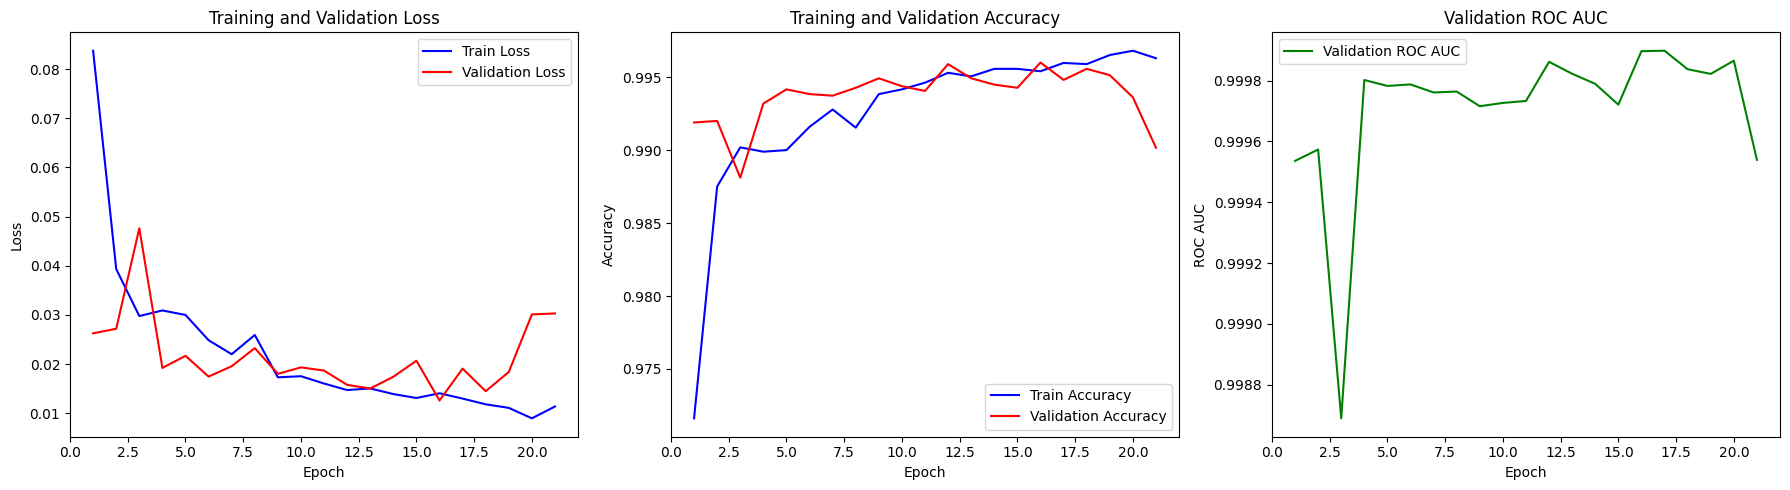

In [13]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, val_roc_auc_scores, 'g-', label='Validation ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

With early stopping, the model saved was the one at epoch 16.

Train Loss: 0.0140

Train F1: 99.54%

Val Loss: 0.0126
 
Val F1: 99.60%

Val ROC AUC: 0.9999

Towards the end of training, the peformance degrades, but that's not an issue because we'll evaluating the model finished training at epoch 16.



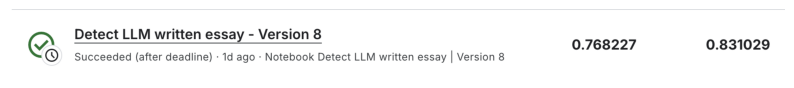

In [8]:
from IPython.display import display
from PIL import Image

img = Image.open("img2.png")

display(img)


In [9]:
X_test = np.vstack(test['embedding'].values)
test_tensor = torch.tensor(X_test, dtype=torch.float32)
test_dataset = torch.utils.data.TensorDataset(test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
test_preds = []

with torch.no_grad():
    for batch_X in test_loader:
        batch_X = batch_X[0].to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())


In [ ]:
submission = pd.DataFrame({
    'id': test['id'],  
    'label': test_preds
})

submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")

## Results
| Configuration          | Train F1 | Val F1 | Val ROC AUC | Train Loss | Val Loss | Kaggle Private Score |
|------------------------|----------|--------|-------------|------------|----------|----------------------|
| **Model 1**             | 0.9865   | 0.9878 | 0.9987      | 0.0407     | 0.0366   | 0.738                |
| **Model 2**             | 0.9954   | 0.9960 | 0.9999      | 0.0140     | 0.0126   | 0.768                |

### Learnig and Takeaway
In this project, we explored the potential of using an OptimizedClassifier with a neural network architecture, combined with Word2Vec embeddings, to detect AI-generated text. The model produced a private Kaggle score of 0.768, demonstrating reasonable performance when using a Word2Vec vector size of 300, a min_count of 7, and a neural network with three hidden layers. This configuration showed improvement over simpler models; however, further fine-tuning could be beneficial. Increasing the vector size and adding layers helped capture more complex patterns, but additional improvements could be achieved by experimenting with transformer-based models or more specialized architectures tailored to the nuances of this task.

### Why something didn't work
Unfortunately, despite the more advanced architecture of the OptimizedClassifier, which includes batch normalization and GELU activations for smoother gradients, along with the use of a larger Word2Vec vector size and increased training epochs, the model still yielded a private score of 0.768, which is below the top-performing models on the leaderboard. One potential reason for this is that the optimized neural network, although powerful in capturing more complex non-linear relationships and features, may not have fully leveraged the specific patterns in the dataset that distinguish AI-generated text from human-written text

### How to improve
The team got first placed attained a private score of 0.98 on Kaggle. They described in their write-up that since it was unknown where the data for the test set was sourced, they created a "Datamix" which contained 8GB worth of human and LLM generated text from a variety of sources. The dataset that I used wasn't even 1GB. They also did quite a bit of customization, like using a custom built tokenizer. I think the biggest impact was their use of a model called DeBERTa, which is a "transformer" architecture that uses neural networks DeBERTa is designed to capture complex patterns and contextual relationships in text through advanced mechanisms. This allows it to understand nuances in language, such as syntax and semantics, which are beyond the reach of Naive Bayes.

https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/473295